# Bonus certificate calculation

INTEL


In [1]:
from FFTpricing import fft_price
from ClosedFormPrice import formulaBS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import yfinance as yf

# Get Market Data

## Interest Term Structure

In [2]:
# from pandas_datareader import data as pdr
# import datetime

# All US Treasury maturities (3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y)
T_list = pd.Series([3/12,6/12,1,2,3,5,7,10,20,30])
# fred_tickers = [
#     "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", 
#     "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"
# ]

# yields.to_parquet('yields.parquet')
yields = pd.read_parquet('yields.parquet')

# start = datetime.datetime.now() - datetime.timedelta(days=30)
# yields = pdr.DataReader(fred_tickers, "fred", start).dropna()
print(yields.tail())

            DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  DGS20  DGS30
DATE                                                                         
2025-05-06    4.33    4.25  3.98  3.78  3.73  3.90  4.10   4.30   4.82   4.81
2025-05-07    4.34    4.27  4.00  3.78  3.72  3.87  4.06   4.26   4.78   4.77
2025-05-08    4.34    4.28  4.05  3.90  3.85  4.00  4.18   4.37   4.86   4.83
2025-05-09    4.34    4.28  4.05  3.88  3.85  4.00  4.18   4.37   4.86   4.83
2025-05-12    4.42    4.29  4.11  3.98  3.97  4.09  4.27   4.45   4.92   4.89


In [3]:
r_term = pd.concat([np.round(yields.iloc[-1].reset_index(drop=True)/100,6),T_list], axis=1)
r_term.columns = ['r','T']

## Dividend yield term structure

In [4]:
q_term = r_term.copy()
q_term.columns = ['q','T']
q_term['q'] = 0.0

## Vanilla Options Data

In [5]:
S0=5886.55

In [6]:
# ticker = '^SPX'
# stock = yf.Ticker(ticker)

# exp_dates = stock.options

# import pickle

# Save
# with open('exp_dates_SPX.pkl', 'wb') as f:
#     pickle.dump(exp_dates, f)

# # Load
# with open('exp_dates.pkl', 'rb') as f:
#     loaded_dates = pickle.load(f)


# # Initialize empty dataframes for calls and puts
# all_calls = pd.DataFrame()
# all_puts = pd.DataFrame()

# for date in exp_dates:
#     try:
#         opt = stock.option_chain(date)
#         opt.calls['expiration'] = date
#         opt.puts['expiration'] = date
        
#         all_calls = pd.concat([all_calls, opt.calls])
#         all_puts = pd.concat([all_puts, opt.puts])
#     except Exception as e:
#         print(f"Error with {date}: {e}")

# all_calls.to_parquet('calls_SPX.parquet')
# all_puts.to_parquet('puts_SPX.parquet')

all_calls = pd.read_parquet('calls_SPX.parquet')
all_puts = pd.read_parquet('puts_SPX.parquet')

In [7]:
all_cals_clean = all_calls[(all_calls['bid']!=0) & (all_calls['ask']!=0) & (all_calls['bid'].notna()) & (all_calls['ask'].notna())].copy()
all_puts_clean = all_puts[(all_puts['bid']!=0) & (all_puts['ask']!=0) & (all_puts['bid'].notna()) & (all_puts['ask'].notna())].copy()

t0 = pd.to_datetime('2025-05-14')
all_cals_clean['T'] = (pd.to_datetime(all_cals_clean['expiration'])-t0).dt.days/365
all_cals_clean = all_cals_clean.rename(columns={"strike": "K"})

all_puts_clean['T'] = (pd.to_datetime(all_puts_clean['expiration'])-t0).dt.days/365
all_puts_clean = all_puts_clean.rename(columns={"strike": "K"})

all_puts_clean['puts'] = (all_puts_clean['bid'] + all_puts_clean['ask'])/2
all_cals_clean['calls'] = (all_cals_clean['bid'] + all_cals_clean['ask'])/2

In [8]:
all_puts_clean = all_puts_clean[all_puts_clean['K']<=(S0+100)].copy()
all_cals_clean = all_cals_clean[all_cals_clean['K']>=(S0-100)].copy()

# all_puts_clean = all_puts_clean[all_puts_clean['volume']<=5]
# all_cals_clean = all_cals_clean[all_cals_clean['volume']>=5]

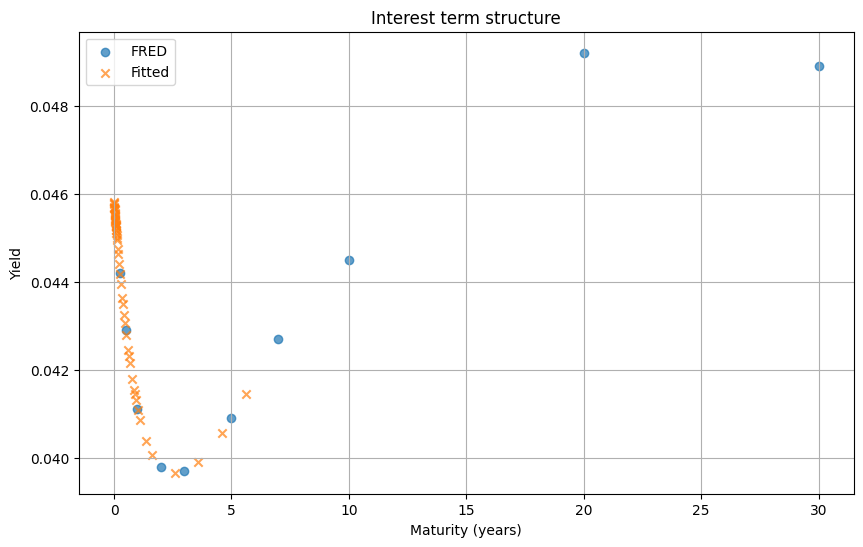

In [9]:
plt.figure(figsize=(10, 6))

r_interp = interp1d(r_term['T'], r_term['r'], kind='cubic', fill_value="extrapolate")
plt.scatter(r_term['T'], r_term['r'], alpha=0.7, marker='o', label='FRED')
plt.scatter(all_puts_clean['T'].unique(),r_interp(all_puts_clean['T'].unique()), alpha=0.7, marker='x', label='Fitted')

# Add labels and legend
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Interest term structure')
plt.legend()

plt.grid(True)
plt.show()

# Callibrate Vanilla Model

In [ ]:
params_BATES = {'kappa':0.4963,
                'theta':0.065,
                'sigma_v':0.2286,
                'rho': - 0.99,
                'v0': 0.0576,
                'lambda': 0.1382,
                'muJ': 0.1791,
                'sigmaJ': 0.1346}

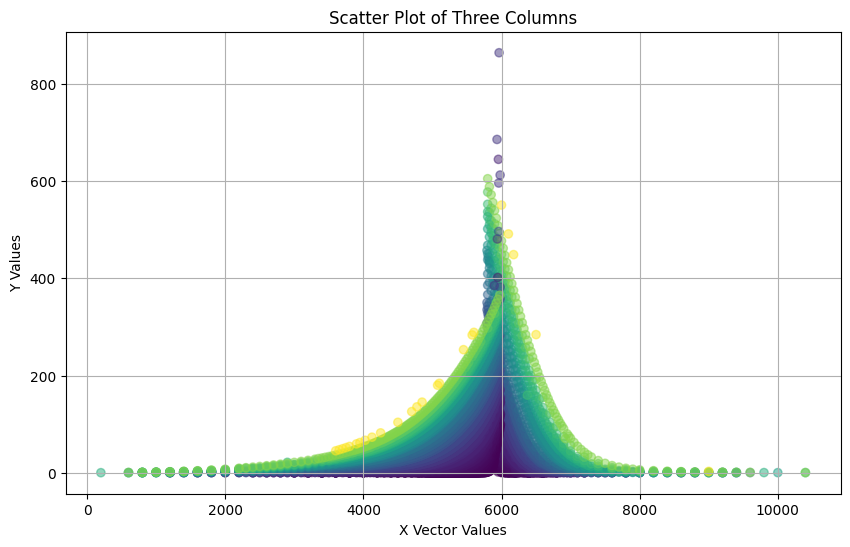

In [34]:
plt.figure(figsize=(10, 6))

all_cals_clean_exp = all_cals_clean[all_cals_clean['T']<=1.5]
all_puts_clean_exp = all_puts_clean[all_puts_clean['T']<=1.5]

plt.scatter(all_cals_clean_exp['K'], all_cals_clean_exp['calls'], alpha=0.5, marker='o', c=all_cals_clean_exp['T'], cmap='viridis')
plt.scatter(all_puts_clean_exp['K'], all_puts_clean_exp['puts'], alpha=0.5, marker='o', c=all_puts_clean_exp['T'], cmap='viridis')

# Add labels and legend
plt.xlabel('X Vector Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of Three Columns')

plt.grid(True)
plt.show()

In [17]:
from FFTpricing import ModelCalibrator

In [28]:
modcab = ModelCalibrator('BATES', S0, r_term, q_term,  all_cals_clean_exp, all_puts_clean_exp, params_BATES)

In [29]:
bounds_BATES = {'kappa': (0.01,10),
                'theta':(0.01,1),
                'sigma_v': (0.01,2),
                'rho': (-0.999, 0.999),
                'v0': (0.01,1),
                'lambda': (0,2),
                'muJ': (-1,1),
                'sigmaJ': (0.01,0.5)}

modcab.set_bounds(bounds_BATES)
positive_only = ['kappa', 'theta', 'sigma_v', 'v0', 'sigmaJ']

In [32]:
modcab.calibrate(positive_only)

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 243.22379346739123
         x: [-1.899e-01 -2.588e+00 -3.656e-01 -7.764e-01 -3.548e+00
              0.000e+00 -1.000e+00 -4.605e+00]
       nit: 84
       jac: [-5.485e-04  1.251e-04  4.161e-03 -3.766e-03  2.015e-03
              6.852e+02  0.000e+00  0.000e+00]
      nfev: 990
      njev: 110
  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>,
 {'kappa': 0.8270822796697042,
  'theta': 0.07518792328625828,
  'sigma_v': 0.6937631594800964,
  'rho': -0.7763884812110039,
  'v0': 0.028782675984418065,
  'lambda': 0.0,
  'muJ': -1.0,
  'sigmaJ': 0.010000000000000004})

In [53]:
prices = modcab.calculate_prices(params=params_BATES)
prices['key'] = prices['K'].round(3).astype(str) + "_" + prices['T'].round(6).astype(str)

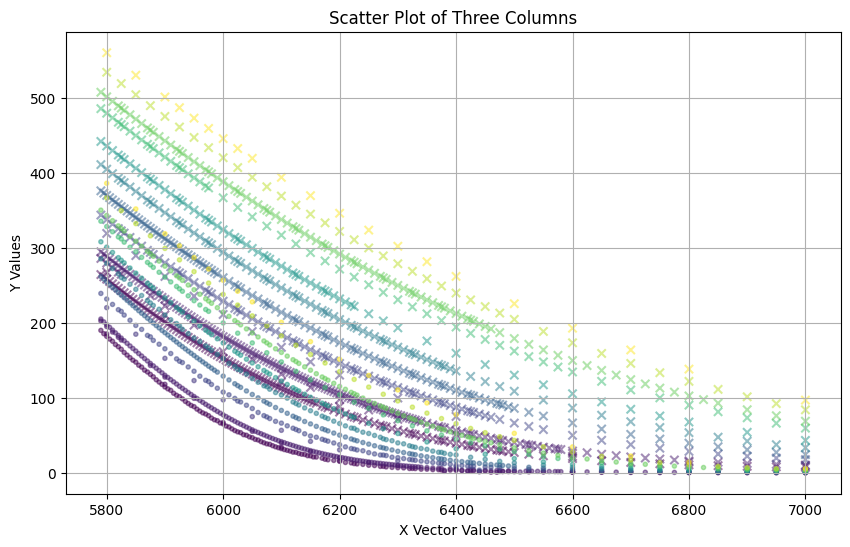

In [54]:
plt.figure(figsize=(10, 6))

all_cals_clean__plot = all_cals_clean[(all_cals_clean['T']<=0.5) & (all_cals_clean['T']>=0.1) & (all_cals_clean['K']<=(7000))]
prices_exp = prices[(prices['T']<=0.5) & (prices['T']>=0.1) & (prices['K']>=(S0-100)) & (prices['K']<=(7000)) & (prices['key'].isin(modcab.keys_calls))]
# all_puts_clean_exp = all_puts_clean[all_puts_clean['T']<=1.5]

plt.scatter(prices_exp['K'], prices_exp['calls'], alpha=0.5, marker='x', c=prices_exp['T'], cmap='viridis')
plt.scatter(all_cals_clean__plot['K'], all_cals_clean__plot['calls'], alpha=0.5, marker='.', c=all_cals_clean__plot['T'], cmap='viridis')

# plt.scatter(all_puts_clean_exp['K'], all_puts_clean_exp['puts'], alpha=0.5, marker='o', c=all_puts_clean_exp['T'], cmap='viridis')

# Add labels and legend
plt.xlabel('X Vector Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of Three Columns')

plt.grid(True)
plt.show()